# Partial Identification of Marginal Treatment Response Functions





_Thomas Wiemann_

_TA Discussion \# 8_  
_ECON 31720_  

_December 1, 2021_  

## Section 0: Preliminaries
This notebook provides and introduction to the methodology introduced in Mogstad, Santos, and Torgovitsky (2018). As a numerical illustration, the example in Mogstad and Torgovitsky (2018) is partially reproduced.

The code can be downloaded via this [link]().

In [1]:
# Load custom package for basis functions
# If not yet installed, run ``using Pkg; Pkg.add(url="https://github.com/thomaswiemann/MyMethods.jl")``.
using MyMethods

# Load additional dependencies
using LinearAlgebra, Statistics
using JuMP, GLPK # for linear optimization
using Plots, LaTeXStrings # for plots

## Section 1: Introduction

Consider the canonical potential outcome framework given by
\begin{align}
\begin{aligned}
    Y &= DY(1) + (1 - D)Y(0), \\
    D &= \mathbf{1}\{U \leq \nu(Z)\},
\end{aligned}
\end{align}
where $D\in\{0, 1\}$, $Y\in\mathbf{R}$ is the realized outcome and $Y(d)$ are the potential outcomes, $U\in\mathbf{R}$ is a continuously distributed latent variable, $\nu$ is an unknown function, and $Z$ are instruments satisfying $Y(0), Y(1), U \perp Z$.

Recall that in this setting with additively separable and continuously distributed $U$, the selection equation can be normalized to 
\begin{align}
\begin{aligned}
    D &= \mathbf{1}\{\tilde{U} \leq p(Z)\},
\end{aligned}
\end{align}
where $\tilde{U}\sim \mathcal{U}(0,1)$ and $p(Z) := P(D = 1\vert Z)$ is the propensity score. For ease of exposition (and with abuse of notation), just redefine $U := \tilde{U}$.

The marginal treatment effect (MTE) can then be defined as
\begin{align}
\begin{aligned}
    \operatorname{MTE}(u) := E\left[Y(1) - Y(0) \vert U = u\right].
\end{aligned}
\end{align}

It is sometimes convenient to define additional parameters: the marginal treatment response (MTR) functions. These are given by
\begin{align}
\begin{aligned}
    &m_d(u) := E\left[Y(d)\vert U = u\right], \quad d \in \{0,1\},\\
    \Rightarrow \qquad & \operatorname{MTE}(u) =m_1(u) - m_0(u).
\end{aligned}
\end{align}

Notice that there exists unobserved treatment heterogeneity if and only if the MTE($u$) is non-constant.

## Section 1: Data Generating Process

To fix ideas, consider the numerical example in Mogstad and Torgovitsky (2018) with a binary outcome $Y$ and treatment $D$, and discrete instrument $Z$. 

Let the instrument $Z$ be such that $P(Z = z) = \frac{1}{4}, z \in \{1, 2, 3, 4\}$. Let the propensity score $p(z) := P(D=1\vert Z = z)$ be given by
\begin{align*}
    p(1) = 0.12, \quad p(2) = 0.29, \quad p(3) = 0.48, \quad \textrm{and} \quad p(4) = 0.78.
\end{align*}

To generate the distribution of $Y$, consider the MTR functions defined by 
\begin{align*}
    \begin{aligned}
        m_0(u) = 0.9 - 1.1u + 0.3u^2 \quad \textrm{and} \quad  m_1(u)=0.35 - 0.3u - 0.05u^2.
    \end{aligned}
\end{align*}
This implies an MTE given by 
\begin{align*}
    m_1(u) - m_0(u) = -0.55 + 0.9u - 0.35^2.
\end{align*}

The below code simulates from this data generating process (DGP) and plots the MTR pair and corresponding MTE. This is a reproduction of Figure 1 in Mogstad and Torgovitsky (2018).

In [2]:
# Simulate from DGP

# Set number of draws from U for integral computation
nMC = 10000

# Define Z and p as in the paper
Z = collect(1:4)
p = [0.12, 0.29, 0.48, 0.78]

# Draw from U for integral computation
u = collect(1:nMC)./(nMC+1)#rand(N)
ind_1 = reduce(hcat, map(u -> u .<= p,u))' # 1{u <= P(z)}

# MTRs
m0 = 0.9 .- 1.1u .+ 0.3u.^2;
m1 = 0.35 .- 0.3u .- 0.05u.^2;

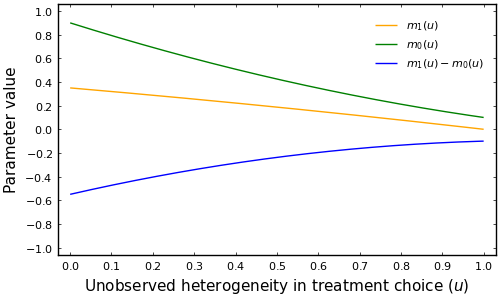

In [3]:
# Recreate Figure 1

# Initialize plot
pyplot(size=(500,300), leg=true);

# Plot parameters
plt=plot(u, m1, line = (:line, :line, 1, 1, :orange), label=L"$m_1(u)$")
plot!(u, m0, line = (:line, :line, 1, 1, :green), label=L"$m_0(u)$")
plot!(u, m1 - m0, line = (:line, :line, 1, 1, :blue), label=L"$m_1(u) - m_0(u)$")

# Additional formatting
plot!(ylim=[-1,1], yticks = -1:0.2:1, xticks = 0:0.1:1, 
    legend=(0.69,0.675), framestyle = :box, grid=false, 
    background_color_legend = nothing)
ylabel!("Parameter value")
xlabel!("Unobserved heterogeneity in treatment choice "*L"$(u)$")

## Section 2: Parameter and Estimand Weights

Suppose the parameter of interest is the ATT defined by $E[Y(1) - Y(0)\vert D = 1]$. Notice that conventionally considered estimands (e.g., the IV slope) don't identify the ATT in this setting with treatment effect heterogeneity.


To better understand identification of our target parameter, it is useful to express the ATT as a linear function of the MTR pair $m:=(m_1, m_0) \in \mathcal{M}$. Following Heckman and Vytacil (2005), we can express many commonly considered target parameters -- including the ATT -- as linear functions of the MTR pair $m:=(m_1, m_0) \in \mathcal{M}$. In particular, for such a target parameter $\beta^*$, we have
\begin{align} 
\begin{aligned}
    \beta^{*} = \Gamma^{*}(m) := E\left[\int_0^1 m_1(u) \omega_1^{*}(u, Z)du\right] + E\left[\int_0^1 m_0(u) \omega_0^{*}(u, Z)du\right], 
\end{aligned}
\end{align}
where $\omega_d^{*}$ are identified weights corresponding to the specific parameter of interest. Expression of the weights can be found in Tables 1-4 of Heckman and Vytacil (2005) or Table 1 of Mogstad and Torgovitsky (2018). 

In the case of the ATT, $\omega_d^{ATT}$ is given by
\begin{align}
    \omega_1^{ATT}(u, z) = \frac{\mathbf{1}\{u \leq p(z)\}}{P(D = 1)} \quad \textrm{and} \quad \omega_0^{ATT}(u, z) =  -\omega_0^{ATT}(u, z).
\end{align}
Identification of the ATT thus corresponds to identification of the MTR pair $m$. 

The following code snippit calculates the (identified) population weights of the ATT and the corresponding ATT (which is unidentified without knowledge of $m$).

In [4]:
# Get ATT weights
w1_ATT = ind_1 ./ mean(p)
w0_ATT = -w1_ATT;

# Calculate the implied ATT
b_ATT = mean(w1_ATT .* m1) + mean(w0_ATT .* m0)
print(round(b_ATT, digits = 3))

-0.368

The ATT is not identified if the MTR pair $m$ is not identified, but not all is lost. To make headway, Mogstad and Torgovitsky (2018) consider restriction on the set of pairs $m$ implied by the insight that IV-like estimands can also be expressed as linear functions of $m$. 

For an IV-like estimand $\beta_s$, we have
\begin{align}
\begin{aligned}
    \beta_s = \Gamma_s(m) := E\left[\int_0^1 m_1(u, Z) \omega_{1s}(u)du\right] + E\left[\int_0^1 m_0(u) \omega_{0s}(u, Z)du\right], \\
\end{aligned}
\end{align}
where $\omega_{1s}(u) = s(1, z)\mathbf{1}\{u > p(z)\}$ and $\omega_{0s}(u) = s(0, z)\mathbf{1}\{u \leq p(z)\}$, for a known measurable function $s$. Table 3 of Mogstad and Torgovitsky (2018) provides the weights for common IV-like estimands.

In the setting of our numerical example, consider the IV and TSLS slope coefficients as two available estimands.

For $\beta_{IV}$, we have
\begin{align}
\begin{aligned}
\beta_{IV} = \frac{Cov(Y, Z)}{Cov(D, Z)}, \quad \textrm{and} \quad s_{IV}(d, z) = \frac{z - E[Z]}{Cov(D,Z)},
\end{aligned}
\end{align}
where $Z$ is a scalar instrument. 

For the $j$th comopnent of $\beta_{TSLS}$, we have
\begin{align}
\begin{aligned}
\beta^{(j)}_{TSLS} = e_j^\top\left(\Pi E[ZX^\top] \right)^{-1}\left(\Pi E[ZY]\right), \quad \textrm{and} \quad s_{IV}(d, z) = e_j^\top\left(\Pi E[ZX^\top] \right)^{-1}\left(\Pi Z\right),
\end{aligned}
\end{align}
where $\Pi := E[X Z^\top]E[ZZ^\top]^{-1}$ and $Z$ is a vector.

The below code snippit calculates the (identified) population weights as well as the implied (identified) slope coefficients.

In [5]:
# Compute \beta_s

# IV slope
Cov_DZ = 0.25 *(sum(Z.*p)) - mean(p)*mean(Z) # Define population moments
s_IV = ((Z .- mean(Z))./Cov_DZ)' # s(d,z)
w1_IV = s_IV .* ind_1 # weight for d = 1
w0_IV = s_IV .* (1 .- ind_1) # weight for d = 0
b_IV = mean(w1_IV .* m1) + mean(w0_IV .* m0); # implied IV slope in DGP

# TSLS slope
ZD = hcat(ones(4)*0.25, 0.25.*p)' # Define population moments
inv_ZZ = I.*4
FS = inv_ZZ * ZD # first stage
s_TSLS = (inv(FS * ZD') * ZD * inv_ZZ)[2,:]' # s(d,z)
w1_TSLS = s_TSLS .* ind_1 # weight for d = 1
w0_TSLS = s_TSLS .* (1 .- ind_1) # weight for d = 0
b_TSLS = mean(w1_TSLS .* m1) + mean(w0_TSLS .* m0); # implied IV slope in DGP

# Print \beta_s
print((b_IV=round(b_IV, digits = 3), b_TSLS=round(b_TSLS, digits = 3)))

(b_IV = -0.275, b_TSLS = -0.269)

## Section 3: From $\beta_s$ to $\beta^*$

Mogstad, Santos, and Torgovitsky (2018) show how known estimands can be leveraged to place restrictions on the MTR pairs. Because target parameters like the ATT are linear functions of the MTRs, restrictions on the latter can be translated to restrictions on the target parameter in a straightforward manner.

Define the set of MTRs consistent with the data as
\begin{align}
    \begin{aligned}
        \mathcal{M}_\mathcal{S} := \{m \in \mathcal{M}: \, \Gamma_s(m) = \beta_s \, \forall s \in \mathcal{S}\},
    \end{aligned}
\end{align}
where $\mathcal{S}$ is the set of considered estimands, and the set of MTR paris $m := (m_1, m_0) \in \mathcal{M}$ may incorporate additional restrictions (derived from economic theory).


Then the set of values of the target parameter $\beta^*$ that is consistent with MTR functions that could have generated the data is given by 
\begin{align}
    \begin{aligned}
        \mathcal{B}^*_\mathcal{S} := \{b \in \mathbf{R}: \, \exists m \in \mathcal{M}_\mathcal{S} \textrm{ s.t. } b = \Gamma^*(m)\}.
    \end{aligned}
\end{align}

When $\mathcal{B}^*_\mathcal{S}$ is a closed interval, bounds on $\beta^*$ can be solved for by
\begin{align}\label{eq_bounds}
    \begin{aligned}
        &\underline{\beta}^* & := \inf_{m \in \mathcal{M}} \Gamma^*(m) \quad \textrm{subject to} \quad \Gamma_s(m) = \beta_s, \forall s \in \mathcal{S}, \\
    \textrm{and} \qquad &    \overline{\beta}^* & := \sup_{m \in \mathcal{M}} \Gamma^*(m) \quad \textrm{subject to} \quad \Gamma_s(m) = \beta_s, \forall s \in \mathcal{S}.
    \end{aligned}
\end{align}

## Section 4: Computating the Bounds

Note that $\mathcal{M}$ is generally infinitely dimensional (i.e., there exists no basis with finitely many elements that spans $\mathcal{M}$). This makes computation of the bounds very difficult.

To address this computational problem, assume that $\mathcal{M}$ is of finite dimension $K_0 + K_1$ with a set of \textit{known} basis functions $\{b_{dk}\}^{K_d}_{k=0}$ for $d = 1, 2$. Every element of this finitely dimensional space of MTR pairs can be represented as a linear combination of the basis functions
\begin{align}
    \begin{aligned}
       \forall (m_1, m_0) \in \mathcal{M}, \: \exists \theta \in \Theta: \:  m_d(u) = \sum_{k=0}^{K_d} \theta_{dk}b_{dk}(u), \: d = 1, 2,
    \end{aligned}
\end{align}
where $\Theta$ is the (finitely dimensional) admissible set of coefficients $\{\theta_{dk}\}^{K_d}_{k=0}$ for $d = 1, 2$. 

To see how this helps with computation, use the basis expansion and simplify $\Gamma^*(m)$ as follows 
\begin{align}
    \begin{aligned}
        \Gamma^*(m) &= E\left[\int_0^1 m_1(u) \omega_1^*(u, Z)du\right] +E\left[\int_0^1 m_0(u) \omega_0^*(u, Z)du\right] \\
        & = E\left[\int_0^1 \sum_{k=0}^{K_1} \theta_{1k}b_{1k}(u) \omega_1^*(u, Z)du\right] +E\left[\int_0^1 \sum_{k=0}^{K_0} \theta_{0k}b_{0k}(u) \omega_0^*(u, Z)du\right] \\
        & = \sum_{k=0}^{K_1} \theta_{1k}E\left[\int_0^1 b_{1k}(u)\omega_1^*(u, Z)du\right] +  \sum_{k=0}^{K_0} \theta_{0k}E\left[\int_0^1  b_{0k}(u)\omega_0^*(u, Z)du\right] \\
        & = \sum_{k=0}^{K_1} \theta_{1k}\gamma^*_{1k} +  \sum_{k=0}^{K_0} \theta_{0k}\gamma^*_{0k} = \sum_{d\in\{0,1\}} \sum_{k=0}^{K_d} \theta_{dk}\gamma^*_{dk},
    \end{aligned}
\end{align}
where we have defined $\gamma^*_{dk} := E\left[\int_0^1 b_{dk}(u)\omega_d^*(u, Z)du\right]$

Similarly we have
\begin{align}
    \begin{aligned}
        \Gamma_s(m) & = \sum_{d \in \{0, 1\}} \sum_{k=0}^{K_d} \theta_{dk} \gamma_{sdk},
    \end{aligned}
\end{align}
where $\gamma_{sdk} := \left[\int_0^1 b_{dk}(u)\omega_{ds}(u, Z)du\right]$.

Then the bounds simplify to 
\begin{align}
    \begin{aligned}
      &  \underline{\beta}^* & := \inf_{\theta \in \Theta} \sum_{d\in\{0,1\}} \sum_{k=0}^{K_d} \theta_{dk}\gamma^*_{dk} \quad \textrm{subject to} \quad \sum_{d \in \{0, 1\}} \sum_{k=0}^{K_d} \theta_{dk} \gamma_{sdk} = \beta_s, \forall s \in \mathcal{S}, \\
       \textrm{and} \qquad &       \overline{\beta}^* & := \sup_{\theta \in \Theta} \sum_{d\in\{0,1\}} \sum_{k=0}^{K_d} \theta_{dk}\gamma^*_{dk} \quad \textrm{subject to} \quad \sum_{d \in \{0, 1\}} \sum_{k=0}^{K_d} \theta_{dk} \gamma_{sdk} = \beta_s, \forall s \in \mathcal{S}.
    \end{aligned}
\end{align}

So for each bound we solve a linear program for $K_0 + K_1$ coefficients. These can be solved reliably using conventional linear optimization methods.

## Section 5: Implementation in Julia

The below code snippit defines a function ``get_gamma`` that takes a matrix where the $K+1$ columns correspond to basis expansions of degree $K$ evaluated at at a value of $u$, with rows corresponding to different values of $u \in [0, 1]$. Similarly, ``w1`` and ``w0`` are vectors of the weights corresponding to different values of $u$. If the values of $u$ are evenly spaced in the integral $[0, 1]$, the $\gamma$ terms can easily be computed via numerical integration by averaging each column across rows. 

In [6]:
# function to get gammas
function get_gamma(B, w1, w0)
    Bw1 = B .* mapslices(mean, w1, dims=2)
    Bw0 = B .* mapslices(mean, w0, dims=2)
    return mapslices(mean, Bw1, dims=1), mapslices(mean, Bw0, dims=1)
end

get_gamma (generic function with 1 method)

The below function ``get_bound`` computes the bound $\overline{\beta}^{ATT}$ (or $\underline{\beta}^{ATT}$ when ``sense="Min"``) given population estimands ``b_IV`` and ``b_TSLS`` as well as the identified $\gamma$ values corresponding to the estimands and the parameter of interest. The function further allows to impose a functional form assumption on the MTR pair. If ``decreasing=false``, then the MTR functions are constrained to be decreasing in $u$.

In [7]:
# Function to obtain lower/upper bound for ATT given IV and TSLS slope
function get_bound(b_IV, b_TSLS,
        gamma_1IV, gamma_0IV,
        gamma_1TSLS, gamma_0TSLS,
        gamma_1ATT, gamma_0ATT;
        sense="Max", decreasing=false)
    # Data parameters
    K = length(gamma_1IV) -1
    
    # initialize model
    m = Model(GLPK.Optimizer)

    # initialize variables
    @variable(m, 1 >= theta[1:(K+1), 1:2] >= 0) # bounded by 0 and 1

    # set constraints
    @constraint(m, IV, sum(theta[:,1].*gamma_1IV') +
        sum(theta[:,2].*gamma_0IV')  == b_IV)
    @constraint(m, TSLS, sum(theta[:,1].*gamma_1TSLS') +
        sum(theta[:,2].*gamma_0TSLS') == b_TSLS)
    
    # Restrict to decreasing MTRs
    if decreasing
        @constraint(m, decreasing[j=1:K,s=1:2], theta[j,s] >= theta[j+1,s])
    end

    # define objective 
    if sense == "Max"
    @objective(m, Max, sum(theta[:,1].*gamma_1ATT') +
            sum(theta[:,2].*gamma_0ATT')) # upper bound
    elseif sense == "Min"
     @objective(m, Min, sum(theta[:,1].*gamma_1ATT') +
        sum(theta[:,2].*gamma_0ATT')) # upper bound
    end

    # solve model
    MOI.set(m, MOI.Silent(), true)
    optimize!(m)
    bound = objective_value(m)
    
    # Return bound
    return bound
end

get_bound (generic function with 1 method)

## Section 4: Two Useful Basis Expansions

For computation of the bounds in practice, researchers must also specify the basis functions. Two sets of basis functions appear particularly appealing: Bernstein polynomials and, in some cases, constant splines.

**Bernstein Polynomials**

For flexible parametric specification of the MTR pairs, researchers can consider Bernstein polynomials of degree $K$, whose basis functions are $b_k^K: [0, 1] \to \mathbf{R}$ such that 
\begin{align}
b_k^K(u) =  \begin{pmatrix}
            K \\ k
        \end{pmatrix}u^k (1 - u)^{K-k}, \quad \forall k = 0, \ldots, K.
\end{align} 
Bernstein polynomials are particularly convenient because key economically relevant functional form restrictions for the MTRs can readily be imposed via linear constraints on $\Theta$.

Let $\{\theta_{dk}\}_{k=0}^{K_d}$, denote the coefficients corresponding to a Bernstein polynomial expansion of $m_d$ of degree $K$. Several nonparametric shape restrictions on $m_d$ can then be imposed as follows:
- $\theta_{dk} \geq 0, \: \forall k \in \{0, \ldots, K\}\quad  \Rightarrow \quad m_d \geq 0$;
- $\theta_{dk} \leq 1, \: \forall k \in \{0, \ldots, K\}\quad  \Rightarrow \quad m_d \leq 1$;
- $\theta_{dk} \leq \theta_{dk+1}, \: \forall k \in \{0, \ldots, K-1\}\quad  \Rightarrow \quad m_d  $ is monotonically increasing;
- $\theta_{dk} - 2\theta_{dk+1} + \theta_{dk+2}, \: \forall k \in \{0, \ldots, K-2\}\quad  \Rightarrow \quad m_d  $ is concave.

**Constant Splines**

When $Z$ has discrete support and the weight functions $\omega^*(u, z)$ for the target parameter are piecewise constant, a constant spline basis can be leveraged for computation of nonparametric bounds.

Let $\{\mathcal{U}_k\}_{k=0}^K$ be a partition of $[0,1]$ such that $\omega_d^*(u, z)$ and $\mathbf{1}\{u \leq p(z)\}$ are constant in $u$ on each $\mathcal{U}_k$. Then define the constant spline basis as $b_k: [0, 1] \to \mathbf{R}$ such that
\begin{align}
          b_{k}(u) = \mathbf{1}\{u \in \mathcal{U}_k\}, \quad \forall k = 0, \ldots, K.
\end{align}
    
In contrast to using a flexible parametric specification (e.g., Bernstein polynomials of degree $K$), the resulting bounds are equivalent to the bounds prior to imposing a finite dimensional structure on $\mathcal{M}$.

## Section 6: Application to the Numerical Example

We can now put things to practice. This section computes bounds for the ATT in the DGP of Section 1 given the population estimands ``b_IV`` and ``b_TSLS`` defined in Section 2. To illustrate the tradeoff between parametric assumptions and strength of the conclusions, bounds are calculated using both a flexible parametric specification using Bernstein polynomials of various degrees as well as using constant splines. The nonparametric shape restriction of decreasing MTRs is also considered.

The below code computes the bounds using Bernstein polynomial expensions of various degrees with and without restricting the MTRs to be decreasing in $u$. The Bernstein polynomial basis are implemented in the ``MyMethods`` package ([GitHub link](https://github.com/thomaswiemann/MyMethods.jl/blob/main/src/FUN/mySieve.jl)).

In [8]:
# Compute bounds with flexible parametric specification

# Compute bounds for different polynomial degrees
p_bounds = zeros(2, 2, 19)
for k in 1:19
    # Get Bernstein poly basis terms and compute the gamma
    Bernstein = MyMethods.get_basis(u, "Bernstein", k, nothing)
    gamma_1IV, gamma_0IV = get_gamma(Bernstein, w1_IV, w0_IV)
    gamma_1TSLS, gamma_0TSLS = get_gamma(Bernstein, w1_TSLS, w0_TSLS)
    gamma_1ATT, gamma_0ATT = get_gamma(Bernstein, w1_ATT, w0_ATT)

    # Compute the parametric bounds
    for dec in (false,true)
        # lower bound
        p_bounds[dec+1, 1, k] = get_bound(b_IV, b_TSLS,
                gamma_1IV, gamma_0IV,
                gamma_1TSLS, gamma_0TSLS,
                gamma_1ATT, gamma_0ATT,
                sense = "Min", decreasing = dec)

        # upper bound
        p_bounds[dec+1, 2, k] = get_bound(b_IV, b_TSLS,
                gamma_1IV, gamma_0IV,
                gamma_1TSLS, gamma_0TSLS,
                gamma_1ATT, gamma_0ATT,
                sense = "Max", decreasing = dec)
    end
end

Since $Z$ has discrete support, the nonparametric bounds can be computed using an appropriate constant spline basis. As before, the basis functions are implemented in the ``MyMethods`` package. 

In [9]:
# Compute nonparametric bounds

# Get constant splines (indicator specificaton) and compute the gamma
CSplines = MyMethods.get_basis(u, "CSplines2", 3, p)[:,1:4] 
gamma_1IV, gamma_0IV = get_gamma(CSplines, w1_IV, w0_IV)
gamma_1TSLS, gamma_0TSLS = get_gamma(CSplines, w1_TSLS, w0_TSLS)
gamma_1ATT, gamma_0ATT = get_gamma(CSplines, w1_ATT, w0_ATT)

# Compute the nonparametric bounds
np_bounds = zeros(2,2)
for dec in (false,true)
    # lower bound
    np_bounds[dec+1, 1] = get_bound(b_IV, b_TSLS,
            gamma_1IV, gamma_0IV,
            gamma_1TSLS, gamma_0TSLS,
            gamma_1ATT, gamma_0ATT,
            sense = "Min", decreasing = dec)
    
    # upper bound
    np_bounds[dec+1, 2] = get_bound(b_IV, b_TSLS,
            gamma_1IV, gamma_0IV,
            gamma_1TSLS, gamma_0TSLS,
            gamma_1ATT, gamma_0ATT,
            sense = "Max", decreasing = dec)
end

# cast np_bounds to dimension of p_bounds
np_bounds = reshape(repeat(np_bounds, 19)', (2, 2, 19)); 

The results are visualized in the below figure. This reproduces Figure 6 of Mogstad and Torgovistky (2018).

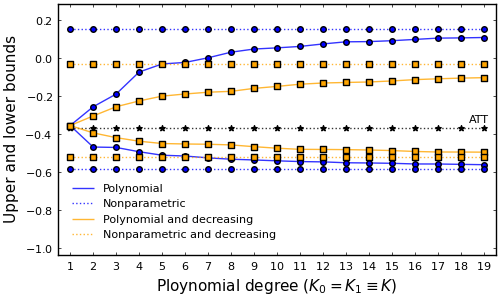

In [10]:
# Plot the bounds

# Initialize plot
pyplot(size=(500,300), leg=true);
_x = collect(1:19)

# ATT 
plt=plot(_x,ones(19)*b_ATT, line = (:line, :dot, 0.8, 1, :black), label="")
plot!(_x,ones(19)*b_ATT, seriestype = :scatter, markershape=:star5, markersize=4, color=:black, label="")
annotate!((19.24,-0.325, text("ATT", :black, :right, 8)))

# parametric bounds
plot!(_x, p_bounds[1,1,:], line = (:line, :line, 0.8, 1, :blue), label = "Polynomial")
plot!(_x, p_bounds[1,1,:], seriestype = :scatter, markershape=:circle, markersize=4, color=:blue, label="")
plot!(_x, p_bounds[1,2,:], line = (:line, :line, 0.8, 1, :blue), label="")
plot!(_x, p_bounds[1,2,:], seriestype = :scatter, markershape=:circle, markersize=4, color=:blue, label="")

# nonparametric bounds
plot!(_x, np_bounds[1,1,:], line = (:line, :dot, 0.8, 1, :blue), label="Nonparametric")
plot!(_x, np_bounds[1,1,:], seriestype = :scatter, markershape=:circle, markersize=4, color=:blue, label="")
plot!(_x, np_bounds[2,1,:], line = (:line, :dot, 0.8, 1, :blue), label="")
plot!(_x, np_bounds[2,1,:], seriestype = :scatter, markershape=:circle, markersize=4, color=:blue, label="")

# parametric bounds w/ decreasing MTRs
plot!(_x, p_bounds[2,1,:], line = (:line, :line, 0.8, 1, :orange), label="Polynomial and decreasing")
plot!(_x, p_bounds[2,1,:], seriestype = :scatter, markershape=:rect, markersize=4, color=:orange, label="")
plot!(_x, p_bounds[2,2,:], line = (:line, :line, 0.8, 1, :orange), label="")
plot!(_x, p_bounds[2,2,:], seriestype = :scatter, markershape=:rect, markersize=4, color=:orange, label="")

# nonparametric bounds w/ decreasing MTRs
plot!(_x, np_bounds[1,2,:], line = (:line, :dot, 0.8, 1, :orange), label="Nonparametric and decreasing")
plot!(_x, np_bounds[1,2,:], seriestype = :scatter, markershape=:rect, markersize=4, color=:orange, label="")
plot!(_x, np_bounds[2,2,:], line = (:line, :dot, 0.8, 1, :orange), label="")
plot!(_x, np_bounds[2,2,:], seriestype = :scatter, markershape=:rect, markersize=4, color=:orange, label="")

# Additional formatting
plot!(ylim=[-1,0.25], yticks = -1:0.2:0.4, xticks = 1:1:19, 
    legend=(0,0), framestyle = :box, grid=false, 
    background_color_legend = nothing)
ylabel!("Upper and lower bounds")
xlabel!("Ploynomial degree "*L"$(K_0=K_1\equiv K)$")

In line with expectations, the bounds from the flexible parametric specifications are always narrower than the nonparametric bounds and widen with increasing degree of the polynomial $K$. The figure also illustrates that nonparametric shape restrictions can contain substantial identifying power, as the bound computed under the restriction of decreasing MTRs are noticeably narrower than their counterparts.

## Section 7: Estimation

Notice that the numerical example in this notebook considered population weights and estimands. In practice, of course, these are typically not available and thus have to be replaced with their sampele analogs -- that is, $\Gamma^*, \Gamma_s$, and $\beta_s$ are point identified but need to be estimated. 

The estimated bounds can be specified as
\begin{align}
    \begin{aligned}
      &  \hat{\underline{\beta}}^* & := \inf_{\theta \in \Theta} \sum_{d\in\{0,1\}} \sum_{k=0}^{K_d} \theta_{dk}\hat{\gamma}^*_{dk} \quad \textrm{subject to} \quad \sum_{d \in \{0, 1\}} \sum_{k=0}^{K_d} \theta_{dk} \hat{\gamma}_{sdk} = \hat{\beta}_s, \forall s \in \mathcal{S}, \\
       \textrm{and} \qquad &       \hat{\overline{\beta}}^* & := \sup_{\theta \in \Theta} \sum_{d\in\{0,1\}} \sum_{k=0}^{K_d} \theta_{dk}\hat{\gamma}^*_{dk} \quad \textrm{subject to} \quad \sum_{d \in \{0, 1\}} \sum_{k=0}^{K_d} \theta_{dk} \hat{\gamma}_{sdk} = \hat{\beta}_s, \forall s \in \mathcal{S}.
    \end{aligned}
\end{align}

Unfortunately, the linear programs defined above sometimes don't have any feasible solution. This is because the estimated $\hat{\beta}_s$ don't necessarily correspond exactly to $\sum_{d \in \{0, 1\}} \sum_{k=0}^{K_d} \theta_{dk} \hat{\gamma}_{sdk}$ for any $\theta \in \Theta$ in finite samples (even if they do in the population!). 

A solution is to select $\theta$ such that the estimands correspond as closely to $\hat{\Gamma}_s$. For this purpose, define
\begin{align}
    \hat{Q}^*_s := \min_{\theta \in \Theta} \hat{Q}_s(\theta) := \min_{\theta \in \Theta} \left\|\hat{\beta}_s - \sum_{d \in \{0, 1\}} \sum_{k=0}^{K_d} \theta_{dk} \hat{\gamma}_{sdk}\right\|,
\end{align}
$\forall s \in \mathcal{S}$. Then relax the above estimated bounds as follows:
\begin{align}
    \begin{aligned}
      &  \tilde{\underline{\beta}}^* & := \inf_{\theta \in \Theta} \sum_{d\in\{0,1\}} \sum_{k=0}^{K_d} \theta_{dk}\hat{\gamma}^*_{dk} \quad \textrm{subject to} \quad Q_s(\theta) \leq \hat{Q}^*_s, \forall s \in \mathcal{S}, \\
       \textrm{and} \qquad &       \tilde{\overline{\beta}}^* & := \sup_{\theta \in \Theta} \sum_{d\in\{0,1\}} \sum_{k=0}^{K_d} \theta_{dk}\hat{\gamma}^*_{dk} \quad \textrm{subject to} \quad Q_s(\theta) \leq \hat{Q}^*_s, \forall s \in \mathcal{S}.
    \end{aligned}
\end{align}

Implementation for these relaxed estimated bounds is a straightforward extension of the functions provided in this notebook.

Characterization of the sampling uncertainty for these bounds is challenging. The working paper of Mogstad, Santos, and Torgovitsky (2017) provides a discussion ([NBER link](https://www.nber.org/papers/w23568)).